In [10]:
import pandas as pd
import numpy as np
import networkx as nx

# Load the pairwise similarity file
df = pd.read_excel("/Users/jessicakamal/pairwise_similarity.xlsx")

# Get all unique tweets
tweets = pd.unique(df[["Tweet 1", "Tweet 2"]].values.ravel())

# Create mappings
tweet_to_idx = {tweet: idx for idx, tweet in enumerate(tweets)}
idx_to_tweet = {idx: tweet for tweet, idx in tweet_to_idx.items()}
n = len(tweets)

# Build adjacency matrix using threshold
threshold = 0.35
adj_matrix = np.zeros((n, n))

for _, row in df.iterrows():
    t1, t2, sim = row["Tweet 1"], row["Tweet 2"], row["Similarity Score"]
    if sim >= threshold:
        i, j = tweet_to_idx[t1], tweet_to_idx[t2]
        adj_matrix[i, j] = sim
        adj_matrix[j, i] = sim  # symmetry

# Build graph and compute PageRank
graph = nx.from_numpy_array(adj_matrix)
scores = nx.pagerank(graph)

# Get top 25 ranked tweet indices
top_indices = sorted(scores, key=scores.get, reverse=True)[:45]
summary = [idx_to_tweet[i] for i in top_indices]

# Save summary to an Excel file without header
summary_df = pd.DataFrame(summary)
summary_file = "lexrank_summary_meetoo.xlsx"
summary_df.to_excel(summary_file, index=False, header=False)

print(f"✅ LexRank summary saved to '{summary_file}' (no header row)")


✅ LexRank summary saved to 'lexrank_summary_meetoo.xlsx' (no header row)


👨 Matched Male Words & Frequencies:
men: 9
man: 4
his: 2
he: 2
him: 2
boys: 1

👩 Matched Female Words & Frequencies:
women: 24
girls: 6
her: 5
woman: 3
she: 2
feminism: 2
lady: 1
females: 1
femininity: 1
feminist: 1

🧮 Total Gendered Mentions: 66
📘 Weighted Male Score: 0.303030
📕 Weighted Female Score: 0.696970
📊 Weighted Inclusion Bias Score (female - male): 0.393939
🟣 Summary is biased toward females.


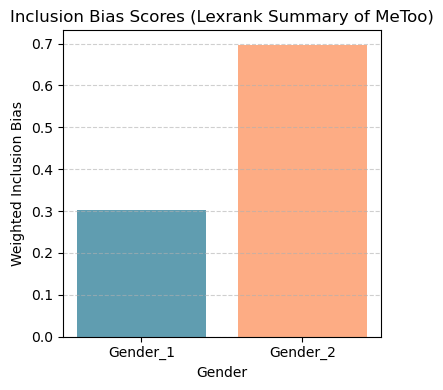

In [8]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
from collections import Counter

# ✅ Use Treebank tokenizer to avoid punkt issues
tokenizer = TreebankWordTokenizer()

# 🔧 Preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return tokenizer.tokenize(text)

# 📥 Load gender word lists
male_words = pd.read_csv("/Users/jessicakamal/male_list.csv", header=None)[0].str.lower().tolist()
female_words = pd.read_csv("/Users/jessicakamal/female_list.csv", header=None)[0].str.lower().tolist()
male_set = set(male_words)
female_set = set(female_words)

# 📄 Load LSA summary content
summary_df = pd.read_excel("/Users/jessicakamal/lexrank_summary_meetoo.xlsx", header=None)
sentences = summary_df[0].dropna().astype(str).tolist()
combined_summary = " ".join(sentences)

# 🧹 Tokenize and count frequencies
tokens = preprocess(combined_summary)
word_freq = Counter(tokens)

# 🧮 Match gendered terms and their frequencies
matched_male = {word: word_freq[word] for word in male_set if word in word_freq}
matched_female = {word: word_freq[word] for word in female_set if word in word_freq}

# 📊 Calculate weighted inclusion bias
total_mentions = sum(matched_male.values()) + sum(matched_female.values())

if total_mentions == 0:
    male_score = female_score = bias_score = 0.0
else:
    male_score = sum(matched_male.values()) / total_mentions
    female_score = sum(matched_female.values()) / total_mentions
    bias_score = female_score - male_score

# 📢 Print frequencies
print("👨 Matched Male Words & Frequencies:")
for word, freq in sorted(matched_male.items(), key=lambda x: -x[1]):
    print(f"{word}: {freq}")

print("\n👩 Matched Female Words & Frequencies:")
for word, freq in sorted(matched_female.items(), key=lambda x: -x[1]):
    print(f"{word}: {freq}")

# 📈 Summary results
print(f"\n🧮 Total Gendered Mentions: {total_mentions}")
print(f"📘 Weighted Male Score: {male_score:.6f}")
print(f"📕 Weighted Female Score: {female_score:.6f}")
print(f"📊 Weighted Inclusion Bias Score (female - male): {bias_score:.6f}")

if bias_score > 0:
    print("🟣 Summary is biased toward females.")
elif bias_score < 0:
    print("🔵 Summary is biased toward males.")
else:
    print("⚪ Summary appears neutral.")

# 📉 Plot results with custom style
plt.figure(figsize=(4, 4))  # Smaller width
plt.bar(["Gender_1", "Gender_2"], [male_score, female_score], color=["#609db0", "#fdac84"])
plt.title("Inclusion Bias Scores (Lexrank Summary of MeToo)")
plt.ylabel("Weighted Inclusion Bias")
plt.xlabel("Gender")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
